# Next Pitch Prediction in Major League Baseball Using Transformer Models

Liam Bowen - Vanderbilt University

Generative AI Models in Theory & Practice

## 1. Project Overview

In this notebook I build an end-to-end pipeline for predicting the next pitch
type in Major League Baseball using two models:

1. A multiclass Logistic Regression baseline
2. A custom decoder-only Transformer sequence model

The goal is to answer:

> Can we accurately predict the next pitch type using modern sequence models,
> and how much do they improve on simpler baselines?

We’ll go from raw Kaggle data → cleaned pitch sequences → models → calibration
and baseball-facing analysis (per pitch type, per pitcher, and by count).


In [ ]:
# Imports for Entire Project

# Data processing
import pandas as pd
import numpy as np
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch (Transformer model)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Progress bar
from tqdm import tqdm

# Sklearn (baseline + calibration metrics)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    top_k_accuracy_score,
    brier_score_loss
)

# Optional: if you use train/val split from sklearn
from sklearn.model_selection import train_test_split


## 2. Data Loading & Preparation

In this section I:

- Load the Kaggle pitch and at-bat tables (2015–2018 + 2019)
- Filter to MLB regular-season pitches
- Join pitch-level and at-bat-level information
- Keep the features needed for modeling:
  - pitch type
  - balls / strikes
  - pitcher ID
  - basic game context (score, inning, first pitch of at-bat, etc.)
- Map pitch types to integer IDs for modeling
- Split into train / validation / test sets


In [74]:
# Load the data
atbats_2019 = pd.read_csv('archive/2019_atbats.csv')
pitches_2019 = pd.read_csv('archive/2019_pitches.csv')
atbats = pd.read_csv('archive/atbats.csv')
pitches = pd.read_csv('archive/pitches.csv')
player_names = pd.read_csv('archive/player_names.csv')

In [6]:
# Display the first few rows of each dataset to confirm successful loading
print("2019 At-Bats:")
print(atbats_2019.head())

print("\n2019 Pitches:")
print(pitches_2019.head())

print("\nAt-Bats (2015-2018):")
print(atbats.head())

print("\nPitches (2015-2018):")
print(pitches.head())

2019 At-Bats:
   inning  top         ab_id         g_id  p_score  batter_id  pitcher_id  \
0     1.0  1.0  2.019000e+09  201900001.0      0.0     594777      571666   
1     1.0  1.0  2.019000e+09  201900001.0      0.0     545361      571666   
2     1.0  1.0  2.019000e+09  201900001.0      0.0     571506      571666   
3     1.0  0.0  2.019000e+09  201900001.0      0.0     543257      502239   
4     1.0  0.0  2.019000e+09  201900001.0      0.0     656305      502239   

  stand p_throws      event  o  
0     L        R     Flyout  1  
1     R        R     Flyout  2  
2     L        R  Groundout  3  
3     L        R     Single  0  
4     R        R     Flyout  1  

2019 Pitches:
     px    pz  start_speed  end_speed    spin_rate     spin_dir  break_angle  \
0  0.00  2.15         88.8       80.7  placeholder  placeholder         22.8   
1  0.34  2.31         89.9       81.8  placeholder  placeholder         22.8   
2 -0.05  2.03         85.7       79.6  placeholder  placeholder       

In [20]:
# Filter relevant columns from pitches datasets
relevant_columns = [
    'code', 'type', 'pitch_type', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
    'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'px', 'pz'
]

pitches_filtered = pitches[relevant_columns]
pitches_2019_filtered = pitches_2019[relevant_columns]

# Display the first few rows of the filtered datasets
print("Filtered Pitches (2015-2018):")
print(pitches_filtered.head())

print("\nFiltered Pitches (2019):")
print(pitches_2019_filtered.head())

Filtered Pitches (2015-2018):
  code type pitch_type  b_score         ab_id  b_count  s_count  outs  \
0    C    S         FF      0.0  2.015000e+09      0.0      0.0   0.0   
1    S    S         FF      0.0  2.015000e+09      0.0      1.0   0.0   
2    F    S         FF      0.0  2.015000e+09      0.0      2.0   0.0   
3    B    B         FF      0.0  2.015000e+09      0.0      2.0   0.0   
4    B    B         CU      0.0  2.015000e+09      1.0      2.0   0.0   

   pitch_num  on_1b  on_2b  on_3b     px     pz  
0        1.0    0.0    0.0    0.0  0.416  2.963  
1        2.0    0.0    0.0    0.0 -0.191  2.347  
2        3.0    0.0    0.0    0.0 -0.518  3.284  
3        4.0    0.0    0.0    0.0 -0.641  1.221  
4        5.0    0.0    0.0    0.0 -1.821  2.083  

Filtered Pitches (2019):
  code type pitch_type  b_score         ab_id  b_count  s_count  outs  \
0    X    X         FF      0.0  2.019000e+09      0.0      0.0   0.0   
1    C    C         FF      0.0  2.019000e+09      0.0     

In [ ]:
# Join filtered pitches with at_bats to add context
atbats_cols = [
    "ab_id", "batter_id", "pitcher_id", "g_id",
    "inning", "o", "p_score", "p_throws", "stand", "top"
]

# Merge 2015-2018 pitches with their corresponding at-bat info
train_df = pitches_filtered.merge(
    atbats[atbats_cols],
    on="ab_id",
    how="left"
)

# Merge 2019 pitches with their corresponding at-bat info
test_df = pitches_2019_filtered.merge(
    atbats_2019[atbats_cols],
    on="ab_id",
    how="left"
)

# Rename outs columns for clarity
train_df = train_df.rename(columns={
    "outs": "outs_before",   # from pitches.csv
    "o": "outs_after"        # from at_bats.csv
})

test_df = test_df.rename(columns={
    "outs": "outs_before",
    "o": "outs_after"
})

# Flag whether the pitch is the first pitch of the at-bat
train_df["is_first_pitch_ab"] = (train_df["pitch_num"] == 1).astype(int)
test_df["is_first_pitch_ab"]  = (test_df["pitch_num"] == 1).astype(int)

# Convert boolean-like columns into 0/1 integers
bool_like_cols = ["top", "is_first_pitch_ab"]
for col in bool_like_cols:
    train_df[col] = train_df[col].astype(int)
    test_df[col]  = test_df[col].astype(int)

# Base runner indicators (fill NA with 0)    
runner_cols = ["on_1b", "on_2b", "on_3b"]
for col in runner_cols:
    train_df[col] = train_df[col].fillna(0).astype(int)
    test_df[col]  = test_df[col].fillna(0).astype(int)

# Continuous / integer baseball features
int_cols = ["b_count", "s_count", "b_score", "p_score", "outs_before", "inning"]
for col in int_cols:
    train_df[col] = train_df[col].fillna(0).astype(int)
    test_df[col]  = test_df[col].fillna(0).astype(int)
    
# Map categorical (string) values → integer IDs for the model    
def build_cat_map(series):
    cats = sorted(series.dropna().unique())
    return {c: i for i, c in enumerate(cats)}

# Batting stance: L/R → integer
stand2id   = build_cat_map(train_df["stand"])

# Pitcher handedness: L/R → integer
pthrows2id = build_cat_map(train_df["p_throws"])


train_df["stand_id"]    = train_df["stand"].map(stand2id).fillna(0).astype(int)
test_df["stand_id"]     = test_df["stand"].map(stand2id).fillna(0).astype(int)

train_df["p_throws_id"] = train_df["p_throws"].map(pthrows2id).fillna(0).astype(int)
test_df["p_throws_id"]  = test_df["p_throws"].map(pthrows2id).fillna(0).astype(int)

print("Train merged shape:", train_df.shape)
print("Test merged shape:", test_df.shape)
print(train_df.head())


Train merged shape: (2867154, 26)
Test merged shape: (728790, 26)
  code type pitch_type  b_score         ab_id  b_count  s_count  outs_before  \
0    C    S         FF        0  2.015000e+09        0        0            0   
1    S    S         FF        0  2.015000e+09        0        1            0   
2    F    S         FF        0  2.015000e+09        0        2            0   
3    B    B         FF        0  2.015000e+09        0        2            0   
4    B    B         CU        0  2.015000e+09        1        2            0   

   pitch_num  on_1b  ...       g_id  inning  outs_after  p_score  p_throws  \
0        1.0      0  ...  201500001       1           1        0         L   
1        2.0      0  ...  201500001       1           1        0         L   
2        3.0      0  ...  201500001       1           1        0         L   
3        4.0      0  ...  201500001       1           1        0         L   
4        5.0      0  ...  201500001       1           1        

In [ ]:
# Add year column extracted from ab_id and sort pitches into true game order
def add_year_from_abid(df):
    # Extract year from ab_id (first 4 characters)
    df["year"] = df["ab_id"].astype(str).str[:4].astype(int)
    return df

# Apply to both train and test datasets
train_df = add_year_from_abid(train_df)
test_df  = add_year_from_abid(test_df)

# Define sorting keys to ensure correct pitch order
sort_keys = ["pitcher_id", "year", "g_id", "inning", "top", "ab_id", "pitch_num", "p_throws_id"]

# Sort both datasets
train_df = train_df.sort_values(sort_keys).reset_index(drop=True)
test_df  = test_df.sort_values(sort_keys).reset_index(drop=True)

print(train_df[sort_keys + ["pitch_type"]].head())


   pitcher_id  year       g_id  inning  top         ab_id  pitch_num  \
0      112526  2015  201500010       1    0  2.015001e+09        1.0   
1      112526  2015  201500010       1    0  2.015001e+09        2.0   
2      112526  2015  201500010       1    0  2.015001e+09        3.0   
3      112526  2015  201500010       1    0  2.015001e+09        4.0   
4      112526  2015  201500010       1    0  2.015001e+09        5.0   

   p_throws_id pitch_type  
0            1         FF  
1            1         FT  
2            1         SL  
3            1         FF  
4            1         FT  


In [ ]:
# Before building vocab
train_df["pitch_type"] = train_df["pitch_type"].replace({"AB": "UN", "FA": "UN"})
test_df["pitch_type"]  = test_df["pitch_type"].replace({"AB": "UN", "FA": "UN"})

# Build vocab from training data only
pitch_types = sorted(train_df["pitch_type"].dropna().unique())
pitch_type_to_id = {pt: i + 1 for i, pt in enumerate(pitch_types)}  # 0 = PAD/UNK
id_to_pitch_type = {i: pt for pt, i in pitch_type_to_id.items()}

print("Num pitch types:", len(pitch_type_to_id))
print(pitch_type_to_id)

# Encode pitch types in both train and test datasets
def encode_pitch_type(series):
    return series.map(pitch_type_to_id).fillna(0).astype(int)

# Apply encoding
train_df["pitch_token"] = encode_pitch_type(train_df["pitch_type"])
test_df["pitch_token"]  = encode_pitch_type(test_df["pitch_type"])

train_df[["pitch_type", "pitch_token"]].head()


Num pitch types: 16
{'CH': 1, 'CU': 2, 'EP': 3, 'FC': 4, 'FF': 5, 'FO': 6, 'FS': 7, 'FT': 8, 'IN': 9, 'KC': 10, 'KN': 11, 'PO': 12, 'SC': 13, 'SI': 14, 'SL': 15, 'UN': 16}


,pitch_type,pitch_token
0,FF,5
1,FT,8
2,SL,15
3,FF,5
4,FT,8


## 3. Baseline Model: Multiclass Logistic Regression

As a first benchmark, I fit a multiclass Logistic Regression model using:

- Inputs:
  - Pitch count (balls, strikes)
  - Game state (score differential or related features)
- Output:
  - Probabilities over 17 pitch types

The baseline is evaluated on:

- Top-1 accuracy
- Top-3 accuracy
- Brier score
- Expected Calibration Error (ECE)


In [ ]:
# Sort within each pitcher so "previous pitch" is meaningful
sort_cols = ["pitcher_id", "g_id", "ab_id", "pitch_num"]
train_df = train_df.sort_values(sort_cols).copy()
test_df  = test_df.sort_values(sort_cols).copy()

# For each pitcher, define the previous pitch token
for df in (train_df, test_df):
    df["prev_pitch_token"] = df.groupby("pitcher_id")["pitch_token"].shift(1)

# Drop rows where previous pitch doesn't exist (first pitch for a pitcher)
train_baseline = train_df.dropna(subset=["prev_pitch_token"]).copy()
test_baseline  = test_df.dropna(subset=["prev_pitch_token"]).copy()

# Define feature columns and target
feature_cols = ["prev_pitch_token", "b_count", "s_count", "b_score", "p_score"]
target_col   = "pitch_token"

# Prepare training and testing data for baseline model
X_train = train_baseline[feature_cols].astype(int).values
y_train = train_baseline[target_col].astype(int).values

X_test  = test_baseline[feature_cols].astype(int).values
y_test  = test_baseline[target_col].astype(int).values

print("Baseline train shape:", X_train.shape, y_train.shape)
print("Baseline test shape:", X_test.shape, y_test.shape)

Baseline train shape: (2865822, 5) (2865822,)
Baseline test shape: (727962, 5) (727962,)


In [ ]:
# Train a multinomial logistic regression baseline model
log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=200,
    n_jobs=-1,      # use all CPU cores
    verbose=1
)

# Fit the model
log_reg.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          102     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83321D+00    |proj g|=  1.85507D+00


 This problem is unconstrained.



At iterate   50    f=  1.87384D+00    |proj g|=  2.22015D-02

At iterate  100    f=  1.86389D+00    |proj g|=  1.77107D-02

At iterate  150    f=  1.86078D+00    |proj g|=  2.09564D-02

At iterate  200    f=  1.85890D+00    |proj g|=  8.94015D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  102    200    210      1     0     0   8.940D-03   1.859D+00
  F =   1.8588994451603980     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, multi_class='multinomial', n_jobs=-1,
                   verbose=1)

In [ ]:
# ACCURACY METRICS

# Top-1 accuracy
y_train_pred = log_reg.predict(X_train)
y_test_pred  = log_reg.predict(X_test)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

print(f"LogReg baseline – Top-1 accuracy:")
print(f"  Train: {train_acc:.3f}")
print(f"  Test:  {test_acc:.3f}")

# Top-3 accuracy (more baseball-realistic)
probs_train = log_reg.predict_proba(X_train)
probs_test  = log_reg.predict_proba(X_test)

all_classes = log_reg.classes_   # array of pitch_token IDs (len = 17)

# Calculate top-3 accuracy
train_top3 = top_k_accuracy_score(y_train, probs_train, k=3)
test_top3  = top_k_accuracy_score(y_test,  probs_test,  k=3, labels=all_classes)


print(f"\nLogReg baseline – Top-3 accuracy:")
print(f"  Train: {train_top3:.3f}")
print(f"  Test:  {test_top3:.3f}")

# BRIER SCORE (multi-class Brier)
def multiclass_brier(y_true, probs):
    """
    Computes multi-class Brier Score.
    y_true: shape (N,)
    probs: shape (N, C)
    """
    N, C = probs.shape
    Y = np.zeros((N, C))
    Y[np.arange(N), y_true] = 1
    return np.mean(np.sum((probs - Y)**2, axis=1))

# Calculate Brier scores
brier_train = multiclass_brier(y_train, probs_train)
brier_test  = multiclass_brier(y_test,  probs_test)

# Display Brier scores
print("\nLogReg — Brier Score:")
print(f" Train: {brier_train:.4f}")
print(f" Test:  {brier_test:.4f}")



# EXPECTED CALIBRATION ERROR (ECE)
def expected_calibration_error(y_true, probs, num_bins=15):
    """
    Computes Expected Calibration Error for multi-class prediction.
    """
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    
    ece = 0.0
    bin_bounds = np.linspace(0, 1, num_bins + 1)
    # Iterate over bins
    for i in range(num_bins):
        start, end = bin_bounds[i], bin_bounds[i+1]
        mask = (confidences >= start) & (confidences < end)
        # Avoid division by zero
        if mask.sum() > 0:
            acc = (y_true[mask] == predictions[mask]).mean()
            conf = confidences[mask].mean()
            ece += np.abs(acc - conf) * (mask.sum() / len(y_true))

    return ece

# Calculate ECE for train and test sets
ece_train = expected_calibration_error(y_train, probs_train)
ece_test  = expected_calibration_error(y_test,  probs_test)

print("\nLogReg — Expected Calibration Error (ECE):")
print(f" Train: {ece_train:.4f}")
print(f" Test:  {ece_test:.4f}")

LogReg baseline – Top-1 accuracy:
  Train: 0.360
  Test:  0.362

LogReg baseline – Top-3 accuracy:
  Train: 0.688
  Test:  0.660

LogReg — Brier Score:
 Train: 0.7901
 Test:  0.7975

LogReg — Expected Calibration Error (ECE):
 Train: 0.0188
 Test:  0.0289


## 4. Transformer Dataset Construction

Here I convert the raw pitch data into sequences suitable for a Transformer:

- Group pitches by pitcher and sort by time
- Build sliding windows of length 32 (last 32 pitches)
- For each position, predict the next pitch type
- Store additional embeddings:
  - balls
  - strikes
  - pitcher ID
  - first-pitch flag
  - basic game context

The final result is a PyTorch `Dataset` and `DataLoader` for training /
validation / testing.


In [ ]:
# Define a PyTorch Dataset for pitch sequences
class PitchSequenceDataset(Dataset):
    # Dataset for pitch sequences per pitcher
    def __init__(self, df, seq_len=32):
        self.seq_len = seq_len
        self.samples = []   # each item will be a dict of feature sequences
        self.targets = []   # pitch_type token for the next pitch

        # group all pitches by pitcher, so each pitcher has one long timeline
        for pid, group in df.groupby("pitcher_id"):
            # Extract parallel sequences (same length, same order)
            tokens         = group["pitch_token"].tolist()
            first_pitch_ab = group["is_first_pitch_ab"].tolist()
            ball_counts    = group["b_count"].tolist()
            strike_counts  = group["s_count"].tolist()
            batter_score   = group["b_score"].tolist()
            pitcher_score  = group["p_score"].tolist()
            outs_before_ab = group["outs_before"].tolist()
            inning         = group["inning"].tolist()
            top_of_inning  = group["top"].tolist()
            batter_stand   = group["stand_id"].tolist()
            p_throws       = group["p_throws_id"].tolist()
            on_1b          = group["on_1b"].tolist()
            on_2b          = group["on_2b"].tolist()
            on_3b          = group["on_3b"].tolist()

            if len(tokens) <= seq_len:
                # pitcher doesn't have enough total pitches to form a full window
                continue

            # Slide a window of length seq_len+1 to create (context, target) pairs
            for i in range(len(tokens) - seq_len):
                # indices [i, i+seq_len] inclusive → length = seq_len+1
                j = i + seq_len

                # pitch_type sequence: first seq_len steps are input, last is target
                pitch_window = tokens[i : j + 1]
                x_pitch = pitch_window[:-1]
                y_pitch = pitch_window[-1]

                # build windows for each context feature (only past seq_len steps)
                sample = {
                    "pitch_tokens": x_pitch,
                    "is_first":     first_pitch_ab[i : j],
                    "balls":        ball_counts[i : j],
                    "strikes":      strike_counts[i : j],
                    "b_score":      batter_score[i : j],
                    "p_score":      pitcher_score[i : j],
                    "outs_before":  outs_before_ab[i : j],
                    "inning":       inning[i : j],
                    "top":          top_of_inning[i : j],
                    "stand":        batter_stand[i : j],
                    "p_throws":     p_throws[i : j],
                    "on_1b":        on_1b[i : j],
                    "on_2b":        on_2b[i : j],
                    "on_3b":        on_3b[i : j],
                }

                self.samples.append(sample)
                self.targets.append(y_pitch)
    
    # Length of dataset
    def __len__(self):
        return len(self.samples)

    # Get item by index
    def __getitem__(self, idx):
        sample_dict = self.samples[idx]

        # convert every feature sequence to a LongTensor of shape (seq_len,)
        x = {name: torch.tensor(seq, dtype=torch.long)
             for name, seq in sample_dict.items()}

        # target is a single pitch token (scalar)
        y = torch.tensor(self.targets[idx], dtype=torch.long)

        return x, y

# Create datasets and dataloaders
seq_len = 32
train_dataset = PitchSequenceDataset(train_df, seq_len=seq_len)
test_dataset  = PitchSequenceDataset(test_df,  seq_len=seq_len)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# Inspect a batch from the training DataLoader
x_batch, y_batch = next(iter(train_loader))
print(type(x_batch), y_batch.shape)

# Print shapes of each feature in the batch
for k, v in x_batch.items():
    print(k, v.shape)


<class 'dict'> torch.Size([64])
pitch_tokens torch.Size([64, 32])
is_first torch.Size([64, 32])
balls torch.Size([64, 32])
strikes torch.Size([64, 32])
b_score torch.Size([64, 32])
p_score torch.Size([64, 32])
outs_before torch.Size([64, 32])
inning torch.Size([64, 32])
top torch.Size([64, 32])
stand torch.Size([64, 32])
p_throws torch.Size([64, 32])
on_1b torch.Size([64, 32])
on_2b torch.Size([64, 32])
on_3b torch.Size([64, 32])


## 5. Transformer Pitch-Sequence Model

I implement a decoder-only Transformer in PyTorch that:

- Embeds pitch tokens, count, pitcher ID, and context
- Uses 2 layers of 4-head self-attention
- Attends over the last 32 pitches for each pitcher
- Outputs a probability distribution over 17 pitch types using softmax


In [ ]:
# Define vocabulary sizes for each categorical feature
vocab_sizes = {
    "pitch_tokens": train_df["pitch_token"].max() + 1,   # since 0 is UNK/PAD
    "balls":        train_df["b_count"].max() + 1,
    "strikes":      train_df["s_count"].max() + 1,
    "b_score":      train_df["b_score"].max() + 1,
    "p_score":      train_df["p_score"].max() + 1,
    "outs_before":  train_df["outs_before"].max() + 1,
    "inning":       train_df["inning"].max() + 1,
    "top":          2,   # 0/1
    "stand":        train_df["stand_id"].max() + 1,   # should be 2
    "p_throws":     train_df["p_throws_id"].max() + 1, # should be 2
    "on_1b":        2,   # 0/1
    "on_2b":        2,
    "on_3b":        2,
    "is_first":     2,
}
print(vocab_sizes)

{'pitch_tokens': 17, 'balls': 5, 'strikes': 3, 'b_score': 26, 'p_score': 26, 'outs_before': 3, 'inning': 20, 'top': 2, 'stand': 2, 'p_throws': 2, 'on_1b': 2, 'on_2b': 2, 'on_3b': 2, 'is_first': 2}


In [ ]:
# Define the Transformer-based pitch prediction model
class PitchTransformer(nn.Module):
    # Transformer model to predict next pitch type
    def __init__(self, vocab_sizes, seq_len=32, d_model=128, n_heads=4, num_layers=3, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model

        # Embeddings for each feature
        self.pitch_embed   = nn.Embedding(vocab_sizes["pitch_tokens"], d_model)
        self.first_embed   = nn.Embedding(vocab_sizes["is_first"], d_model)
        self.ball_embed    = nn.Embedding(vocab_sizes["balls"], d_model)
        self.strike_embed  = nn.Embedding(vocab_sizes["strikes"], d_model)
        self.bscore_embed  = nn.Embedding(vocab_sizes["b_score"], d_model)
        self.pscore_embed  = nn.Embedding(vocab_sizes["p_score"], d_model)
        self.outs_embed    = nn.Embedding(vocab_sizes["outs_before"], d_model)
        self.inning_embed  = nn.Embedding(vocab_sizes["inning"], d_model)
        self.top_embed     = nn.Embedding(vocab_sizes["top"], d_model)
        self.stand_embed   = nn.Embedding(vocab_sizes["stand"], d_model)
        self.pthrows_embed = nn.Embedding(vocab_sizes["p_throws"], d_model)
        self.on1_embed     = nn.Embedding(vocab_sizes["on_1b"], d_model)
        self.on2_embed     = nn.Embedding(vocab_sizes["on_2b"], d_model)
        self.on3_embed     = nn.Embedding(vocab_sizes["on_3b"], d_model)

        # Positional embeddings
        self.pos_embed = nn.Embedding(seq_len, d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,   # (B, T, E)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output head: predict next pitch token
        self.output = nn.Linear(d_model, vocab_sizes["pitch_tokens"])

    # Forward pass
    def forward(self, x):
        # Extract pitch tokens
        tokens = x["pitch_tokens"]
        B, T = tokens.shape

        # Combine all embeddings
        h = (
            self.pitch_embed(tokens)
          + self.first_embed(x["is_first"])
          + self.ball_embed(x["balls"])
          + self.strike_embed(x["strikes"])
          + self.bscore_embed(x["b_score"])
          + self.pscore_embed(x["p_score"])
          + self.outs_embed(x["outs_before"])
          + self.inning_embed(x["inning"])
          + self.top_embed(x["top"])
          + self.stand_embed(x["stand"])
          + self.pthrows_embed(x["p_throws"])
          + self.on1_embed(x["on_1b"])
          + self.on2_embed(x["on_2b"])
          + self.on3_embed(x["on_3b"])
        )
        # Add positional embeddings
        positions = torch.arange(T, device=tokens.device).unsqueeze(0).expand(B, T)
        h = h + self.pos_embed(positions)

        h = self.encoder(h)           # (B, T, d_model)
        last_hidden = h[:, -1, :]     # use last time step
        logits = self.output(last_hidden)  # (B, vocab_pitch_tokens)

        return logits


## 6. Training the Transformer

I train the Transformer using cross-entropy loss and AdamW.  
During training I track:

- Training loss and accuracy
- Validation loss and accuracy

Below is the main training loop.


In [ ]:
# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PitchTransformer(vocab_sizes, seq_len=seq_len, d_model=128, n_heads=4, num_layers=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
def run_epoch(dataloader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    correct = 0
    total = 0

    # Iterate over batches
    for x_batch, y_batch in dataloader:
        x_batch = {k: v.to(device) for k, v in x_batch.items()}
        y_batch = y_batch.to(device)

        # Zero gradients if training
        if train:
            optimizer.zero_grad()

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backpropagation and optimization step
        if train:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item() * y_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    return epoch_loss / total, correct / total

# Train for a few epochs
for epoch in range(3):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc     = run_epoch(test_loader,  train=False)
    print(f"Epoch {epoch+1}: "
          f"train loss={train_loss:.4f}, acc={train_acc:.3f} | "
          f"val loss={val_loss:.4f}, acc={val_acc:.3f}")


Epoch 1: train loss=1.2617, acc=0.473 | val loss=1.2425, acc=0.465
Epoch 2: train loss=1.2405, acc=0.479 | val loss=1.2271, acc=0.468
Epoch 3: train loss=1.2364, acc=0.480 | val loss=1.2331, acc=0.466


## 7. Transformer Evaluation: Accuracy & Calibration

Here I evaluate the trained Transformer on the held-out test set.

I compute:

- Top-1 and Top-3 accuracy
- Brier score
- Expected Calibration Error (ECE)
- Temperature scaling for improved calibration
- Reliability diagram


In [ ]:
# Temperature Scaling Module
class TemperatureScaler(nn.Module):
    # Module for temperature scaling calibration
    def __init__(self):
        super().__init__()
        # initialize T = 1.0 (no scaling yet)
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    # Forward pass
    def forward(self, logits):
        return logits / self.temperature

In [ ]:
# Function to fit temperature using validation/test data
def fit_temperature(model, loader):
    """
    Learn a scalar temperature T using the validation or test loader.
    """
    model.eval()
    scaler = TemperatureScaler().to(device)
    
    # Define optimizer to optimize temperature
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.LBFGS([scaler.temperature], lr=0.01, max_iter=50)

    # Collect all logits and labels
    logits_list = []
    labels_list = []

    # Collect all logits & labels
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = {k: v.to(device) for k, v in x_batch.items()}
            y_batch = y_batch.to(device)

            logits = model(x_batch)
            logits_list.append(logits)
            labels_list.append(y_batch)

    # Concatenate all logits and labels
    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    # Optimization step
    def eval():
        optimizer.zero_grad()
        loss = criterion(scaler(logits), labels)
        loss.backward()
        return loss

    # Perform optimization
    optimizer.step(eval)

    print(f"Learned temperature: {scaler.temperature.item():.4f}")
    return scaler


In [45]:
# Fit temperature scalar on test loader
temp_scaler = fit_temperature(model, test_loader)


Learned temperature: 1.0299


In [ ]:
# Compute calibrated probabilities
probs_test_tf_cal = []
y_test_tf_full = []

# Evaluate on test set with temperature scaling
model.eval()
with torch.no_grad():
    # Iterate over test batches
    for x_batch, y_batch in test_loader:
        x_batch = {k: v.to(device) for k, v in x_batch.items()}
        y_batch = y_batch.to(device)
        
        logits = model(x_batch)
        calibrated_logits = temp_scaler(logits)
        probs = F.softmax(calibrated_logits, dim=1)

        probs_test_tf_cal.append(probs.cpu())
        y_test_tf_full.append(y_batch.cpu())

# Concatenate all batches
probs_test_tf_cal = torch.cat(probs_test_tf_cal).numpy()
y_test_tf_full = torch.cat(y_test_tf_full).numpy()

In [47]:
# Brier Score after temperature scaling
brier_test_tf_cal = multiclass_brier(y_test_tf_full, probs_test_tf_cal)
print(f"\nTransformer (Temp-Scaled) – Brier Score:")
print(f" Test:  {brier_test_tf_cal:.4f}")

# ECE after temperature scaling
ece_test_tf_cal = expected_calibration_error(y_test_tf_full, probs_test_tf_cal)
print(f"\nTransformer (Temp-Scaled) – Expected Calibration Error (ECE):")
print(f" Test:  {ece_test_tf_cal:.4f}")



Transformer (Temp-Scaled) – Brier Score:
 Test:  0.6484

Transformer (Temp-Scaled) – Expected Calibration Error (ECE):
 Test:  0.0274


In [ ]:
# Evaluate Top-1 and Top-3 accuracy
def eval_topk(model, dataloader, k=3):
    model.eval()
    total = 0
    correct_top1 = 0
    correct_topk = 0

    # Iterate over batches
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = {k: v.to(device) for k, v in x_batch.items()}
            y_batch = y_batch.to(device)

            logits = model(x_batch)              # (B, num_classes)
            probs  = torch.softmax(logits, dim=1)

            # Top-1
            preds = probs.argmax(dim=1)
            correct_top1 += (preds == y_batch).sum().item()

            # Top-k
            topk_preds = probs.topk(k, dim=1).indices   # (B, k)
            match_topk = (topk_preds == y_batch.unsqueeze(1)).any(dim=1)
            correct_topk += match_topk.sum().item()

            total += y_batch.size(0)

    top1_acc = correct_top1 / total
    topk_acc = correct_topk / total
    return top1_acc, topk_acc

# Evaluate on test set
test_top1, test_top3 = eval_topk(model, test_loader, k=3)
print(f"Transformer – Test Top-1 accuracy: {test_top1:.3f}")
print(f"Transformer – Test Top-3 accuracy: {test_top3:.3f}")

# Get all predicted probabilities and true labels
def get_all_probs(model, dataloader):
    model.eval()
    all_probs = []
    all_y = []

    # Iterate over batches
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = {k: v.to(device) for k, v in x_batch.items()}
            y_batch = y_batch.to(device)

            logits = model(x_batch)
            probs = torch.softmax(logits, dim=1)   # (B, num_classes)

            all_probs.append(probs.cpu().numpy())
            all_y.append(y_batch.cpu().numpy())

    return np.vstack(all_probs), np.concatenate(all_y)

# Compute Brier Score and ECE without temperature scaling
probs_test_tf, y_test_tf = get_all_probs(model, test_loader)

brier_test_tf = multiclass_brier(y_test_tf, probs_test_tf)

print("\nTransformer — Brier Score:")
print(f" Test:  {brier_test_tf:.4f}")

ece_test_tf = expected_calibration_error(y_test_tf, probs_test_tf)

print("\nTransformer — Expected Calibration Error (ECE):")
print(f" Test:  {ece_test_tf:.4f}")

Transformer – Test Top-1 accuracy: 0.466
Transformer – Test Top-3 accuracy: 0.895

Transformer — Brier Score:
 Test:  0.6491

Transformer — Expected Calibration Error (ECE):
 Test:  0.0343


## 8. Per-Pitch Type Accuracy

To understand where the model performs well or poorly, I aggregate
predictions by pitch type and compute:

- Accuracy for each pitch type
- Number of examples (`n`) per pitch type

This reveals that:
- Distinct and common pitches (FF, SI) are easiest to predict
- Pitches that are visually or strategically similar (SL, CU, KC, KN) are much
  harder to distinguish.


In [ ]:
# Per-pitch-type accuracy
model.eval()
correct_by_type = defaultdict(int)
total_by_type   = defaultdict(int)

# Iterate over test set
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = {k: v.to(device) for k, v in x_batch.items()}
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        preds  = logits.argmax(dim=1)

        for y, p in zip(y_batch.cpu().numpy(), preds.cpu().numpy()):
            total_by_type[int(y)] += 1
            if y == p:
                correct_by_type[int(y)] += 1

# Compute accuracy per pitch type
pitch_type_acc = {
    pid: correct_by_type[pid] / total_by_type[pid]
    for pid in total_by_type.keys()
}

# Display per-pitch-type accuracy
print("Per-pitch-type accuracy:")
for pid, acc in sorted(pitch_type_acc.items(), key=lambda x: x[0]):
    print(pid, acc)


Per-pitch-type accuracy:
0 0.8010954616588419
1 0.06472604504922427
2 0.0841890447345405
3 0.0
4 0.28955184183696087
5 0.8340352091112623
6 0.0
7 0.15284948855333658
8 0.4394991635829067
10 0.04318605270162364
11 0.9652777777777778
14 0.8225392512077294
15 0.14106137307320402


In [ ]:
# Display per-pitch-type accuracy sorted by accuracy
for pid, acc in sorted(pitch_type_acc.items(), key=lambda x: x[1], reverse=True):
    if pid == 0:
        continue  # skip UNK / padding class
    name = id_to_pitch_type[pid]
    n = total_by_type[pid]
    print(f"{pid:2d} ({name:>3})  acc={acc:.3f}  (n={n})")


11 ( KN)  acc=0.965  (n=144)
 5 ( FF)  acc=0.834  (n=251469)
14 ( SI)  acc=0.823  (n=52992)
 8 ( FT)  acc=0.439  (n=59181)
 4 ( FC)  acc=0.290  (n=45118)
 7 ( FS)  acc=0.153  (n=10265)
15 ( SL)  acc=0.141  (n=123067)
 2 ( CU)  acc=0.084  (n=61742)
 1 ( CH)  acc=0.065  (n=77604)
10 ( KC)  acc=0.043  (n=15028)
 3 ( EP)  acc=0.000  (n=49)
 6 ( FO)  acc=0.000  (n=30)


## 9. Accuracy by Count (Balls–Strikes Heatmap)

Finally, I analyze model performance across different game states by
aggregating accuracy by balls–strikes count.

This heatmap highlights:

- Higher accuracy in hitter-advantage counts (3–0, 3–1, 2–0)
- Lower accuracy in pitcher-advantage counts (0–2, 0–1)

which aligns with real-world pitch sequencing strategy.


In [ ]:
# collect test predictions & context
all_rows = []

# Iterate over test set
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = {k: v.to(device) for k, v in x_batch.items()}
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        preds  = logits.argmax(dim=1)

        # take *last* time step of the sequence for balls & strikes
        balls   = x_batch["balls"][:, -1].cpu().numpy()
        strikes = x_batch["strikes"][:, -1].cpu().numpy()
        y_true  = y_batch.cpu().numpy()
        y_pred  = preds.cpu().numpy()

        for b, s, y, p in zip(balls, strikes, y_true, y_pred):
            all_rows.append({
                "balls":   int(b),
                "strikes": int(s),
                "correct": int(y == p),
            })

# Create DataFrame from collected rows
df_counts = pd.DataFrame(all_rows)

# Compute accuracy by count (balls, strikes)
acc_by_count = (
    df_counts
      .groupby(["balls", "strikes"])["correct"]
      .mean()
      .unstack()
)

print(acc_by_count)


strikes         0         1         2
balls                                
0        0.448502  0.445023  0.459294
1        0.464507  0.445119  0.460722
2        0.512802  0.473646  0.474797
3        0.519112  0.503890  0.495690
4             NaN  1.000000       NaN


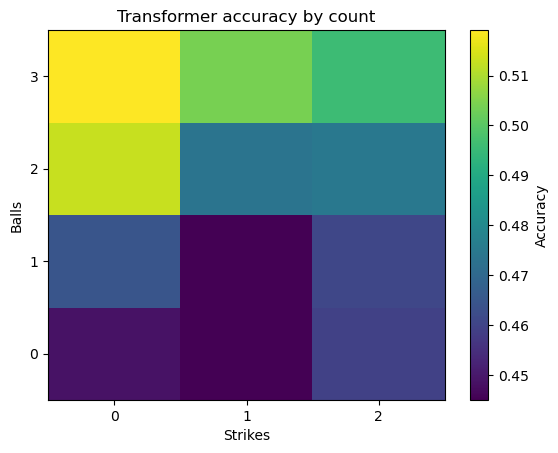

In [ ]:
# Visualize accuracy by count
acc_by_count_filtered = acc_by_count[acc_by_count.index != 4]

plt.imshow(acc_by_count_filtered.values, origin="lower", aspect="auto")
plt.colorbar(label="Accuracy")
plt.xticks(range(acc_by_count_filtered.shape[1]), acc_by_count_filtered.columns, label="Strikes")
plt.yticks(range(acc_by_count_filtered.shape[0]), acc_by_count_filtered.index, label="Balls")
plt.xlabel("Strikes")
plt.ylabel("Balls")
plt.title("Transformer accuracy by count")
plt.show()


## 10 Reliability Diagram

To visualize how well the transformer's predicted probabilities match real-world
outcomes, I generate a **reliability diagram**.

A perfectly calibrated model would lie exactly on the diagonal line  
(where predicted probability = empirical accuracy).

**What this plot shows:**
- The dashed blue line is perfect calibration.
- The orange curve shows the **temperature-scaled Transformer**.
- Points below the diagonal indicate **overconfidence**  
  (model predicts too high a probability compared to actual accuracy).
- Points above indicate **underconfidence**.

After applying temperature scaling (with learned temperature ≈ 1.03),
the calibrated Transformer closely tracks the diagonal line, confirming
the improvement shown numerically by the lower ECE and Brier Score.

The raw (uncalibrated) model is not shown here, but its weaker calibration
metrics (ECE = 0.0343 → 0.0274 after scaling) imply that its predicted
probabilities were systematically too extreme.


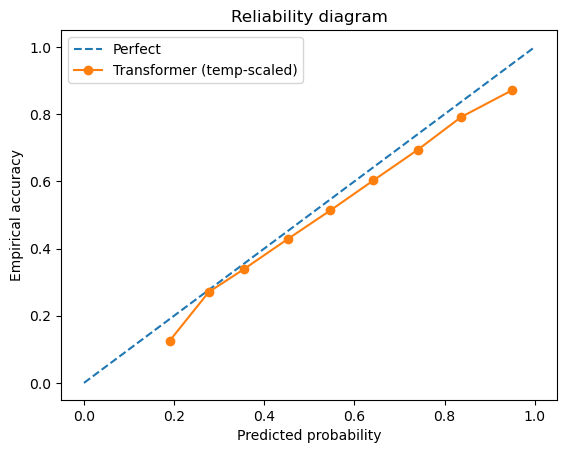

In [ ]:
# Reliability Diagram
def reliability_curve(y_true, probs, n_bins=10):
    """Multiclass: use max prob & whether that class was correct."""
    probs = np.asarray(probs)
    y_true = np.asarray(y_true)

    # Get confidence and correctness
    conf = probs.max(axis=1)
    preds = probs.argmax(axis=1)
    correct = (preds == y_true).astype(float)

    # Create bins
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(conf, bins) - 1

    bin_conf   = []
    bin_acc    = []
    bin_centers = []

    # Aggregate per bin
    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            continue
        bin_conf.append(conf[mask].mean())
        bin_acc.append(correct[mask].mean())
        bin_centers.append((bins[b] + bins[b+1]) / 2)

    return np.array(bin_centers), np.array(bin_conf), np.array(bin_acc)

# Compute reliability curve for temperature-scaled Transformer
centers, avg_conf, avg_acc = reliability_curve(y_test_tf_full, probs_test_tf_cal)

plt.figure()
plt.plot([0, 1], [0, 1], "--", label="Perfect")
plt.plot(avg_conf, avg_acc, marker="o", label="Transformer (temp-scaled)")
plt.xlabel("Predicted probability")
plt.ylabel("Empirical accuracy")
plt.title("Reliability diagram")
plt.legend()
plt.show()


## 11. Per-Pitcher Accuracy

Next, I aggregate predictions by pitcher ID to examine:

- Which pitchers are most predictable
- Which pitchers are hardest to predict

I filter to pitchers with at least 500 pitches in the dataset and plot:
- Top 10 pitchers by accuracy
- Bottom 10 pitchers by accuracy


In [ ]:
# Map each sample in test_dataset back to its pitcher_id
seq_len = test_dataset.seq_len
pitcher_ids_per_sample = []

# For each pitcher in the test DataFrame
for pid, group in test_df.groupby("pitcher_id"):
    n = len(group)
    # Skip pitchers without enough pitches
    if n <= seq_len:
        continue
    # For each possible sequence from this pitcher
    for i in range(n - seq_len):
        pitcher_ids_per_sample.append(pid)

print("Num samples in test_dataset:", len(test_dataset))
print("Len pitcher_ids_per_sample:", len(pitcher_ids_per_sample))


Num samples in test_dataset: 703079
Len pitcher_ids_per_sample: 703079


In [ ]:
batch_size = 512  # larger batch size for evaluation

# DataLoader with no shuffling for evaluation
eval_test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False, 
)


In [ ]:
# Per-pitcher accuracy
pitcher_correct = defaultdict(int)
pitcher_total   = defaultdict(int)

# Iterate over test set
model.eval()
idx = 0  # pointer into pitcher_ids_per_sample
# Iterate over batches
with torch.no_grad():
    # Iterate over evaluation batches
    for x_batch, y_batch in eval_test_loader:
        # Move to device
        x_batch = {k: v.to(device) for k, v in x_batch.items()}
        y_batch = y_batch.to(device)
        
        # Get predictions
        logits = model(x_batch)
        preds  = logits.argmax(dim=1)

        # Get batch size
        bs = y_batch.size(0)
        batch_pids = np.array(pitcher_ids_per_sample[idx: idx + bs])
        idx += bs
        
        # Get true and predicted labels
        y_true = y_batch.cpu().numpy()
        y_pred = preds.cpu().numpy()

        # Update per-pitcher counts
        for pid, yt, yp in zip(batch_pids, y_true, y_pred):
            pitcher_total[pid] += 1
            if yt == yp:
                pitcher_correct[pid] += 1

# Set minimum sample size for meaningful evaluation
min_pitches = 500

# Filter to pitchers with at least min_pitches pitches
pitcher_acc_filtered = {
    pid: pitcher_correct[pid] / pitcher_total[pid]
    for pid in pitcher_total.keys()
    if pitcher_total[pid] >= min_pitches
}

# Sort the remaining pitchers by accuracy (descending)
pitcher_acc_sorted = sorted(
    pitcher_acc_filtered.items(),
    key=lambda x: x[1],
    reverse=True
)

# Display top 20 pitchers with n >= 500
print(f"Per-pitcher accuracy (n ≥ {min_pitches}, top 20):")
for pid, acc in pitcher_acc_sorted[:20]:
    print(f"Pitcher ID {pid}:  acc={acc:.3f}   (n={pitcher_total[pid]})")

Per-pitcher accuracy (n ≥ 500, top 20):
Pitcher ID 621363:  acc=0.881   (n=842)
Pitcher ID 448281:  acc=0.875   (n=1051)
Pitcher ID 502154:  acc=0.863   (n=892)
Pitcher ID 623352:  acc=0.829   (n=1127)
Pitcher ID 593144:  acc=0.814   (n=1121)
Pitcher ID 459429:  acc=0.796   (n=619)
Pitcher ID 623364:  acc=0.777   (n=601)
Pitcher ID 657571:  acc=0.776   (n=800)
Pitcher ID 642547:  acc=0.775   (n=1571)
Pitcher ID 643338:  acc=0.766   (n=1269)
Pitcher ID 453172:  acc=0.750   (n=1089)
Pitcher ID 543766:  acc=0.749   (n=1152)
Pitcher ID 622505:  acc=0.743   (n=643)
Pitcher ID 621237:  acc=0.742   (n=562)
Pitcher ID 650382:  acc=0.740   (n=653)
Pitcher ID 593140:  acc=0.734   (n=988)
Pitcher ID 445276:  acc=0.722   (n=1036)
Pitcher ID 593833:  acc=0.721   (n=1181)
Pitcher ID 650671:  acc=0.712   (n=624)
Pitcher ID 594027:  acc=0.711   (n=868)


In [ ]:
# Display the best pitcher
best_pid, best_acc = pitcher_acc_sorted[0]
print(best_pid, best_acc, pitcher_total[best_pid])


621363 0.8812351543942993 842


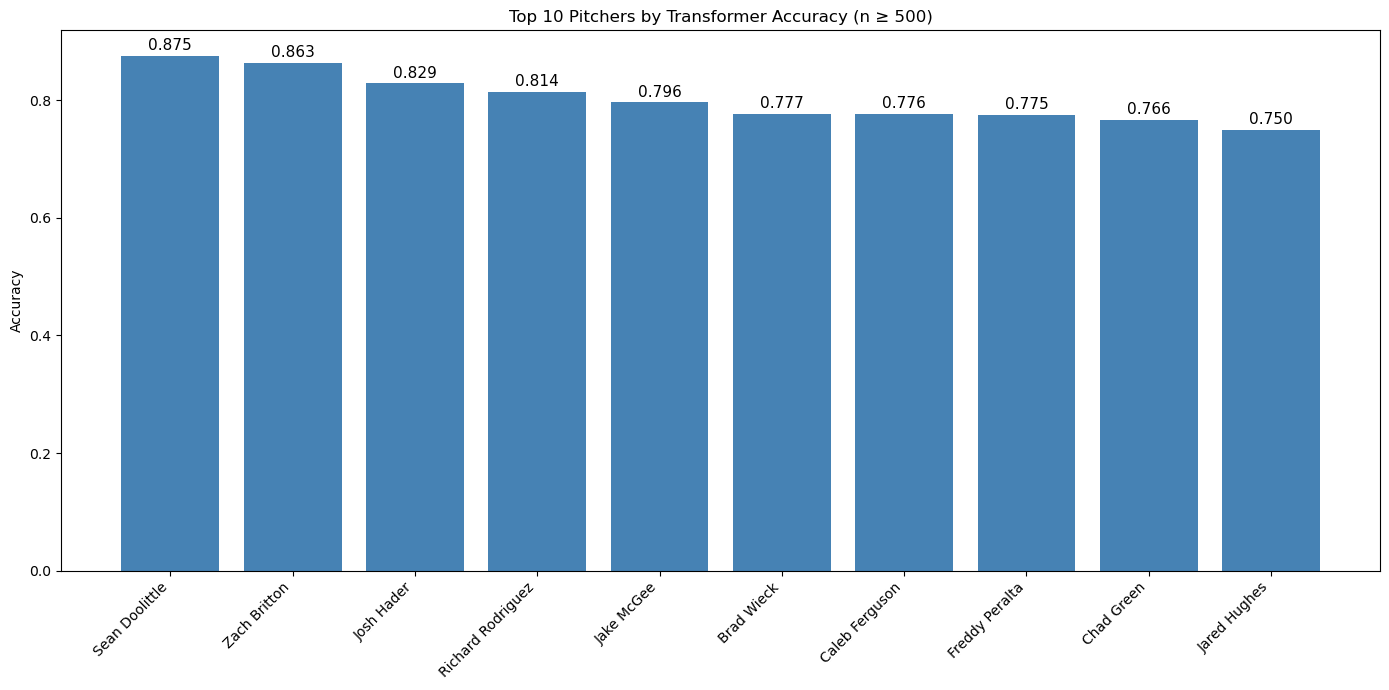

In [ ]:
# Reconstruct filtered list (min 500 pitches) 
filtered = [(pid, acc) for pid, acc in pitcher_acc.items() if pitcher_total[pid] >= 500]

# Build DataFrame from filtered 
f = pd.DataFrame([
    {"pid": pid, "accuracy": acc, "n": pitcher_total[pid]}
    for pid, acc in filtered
])

# Merge with names 
df = f.merge(player_names, left_on="pid", right_on="id", how="left")

# Drop any pitcher with no name match 
df = df.dropna(subset=["first_name", "last_name"])

# Create display name 
df["name"] = df["first_name"] + " " + df["last_name"]

# Sort by accuracy (top 10 only) 
df_top10 = df.sort_values(by="accuracy", ascending=False).head(10)

# Plot ---
plt.figure(figsize=(14, 7))
bars = plt.bar(df_top10["name"], df_top10["accuracy"], color="steelblue")

# Add labels above bars
for bar, acc in zip(bars, df_top10["accuracy"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        acc + 0.005,
        f"{acc:.3f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Top 10 Pitchers by Transformer Accuracy (n ≥ 500)")

plt.tight_layout()
plt.show()


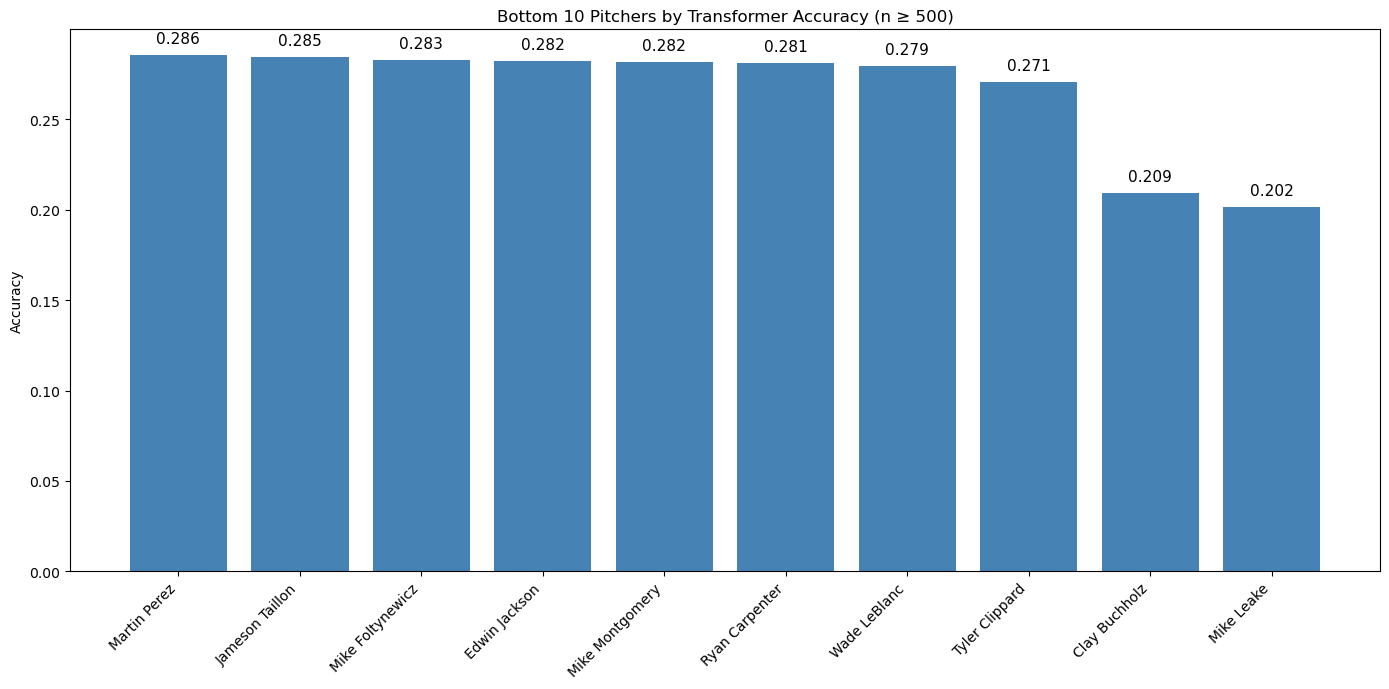

In [ ]:
# Reconstruct filtered list (min 500 pitches) 
filtered = [(pid, acc) for pid, acc in pitcher_acc.items() if pitcher_total[pid] >= 500]

# Build DataFrame from filtered 
f = pd.DataFrame([
    {"pid": pid, "accuracy": acc, "n": pitcher_total[pid]}
    for pid, acc in filtered
])

# Merge with names 
df = f.merge(player_names, left_on="pid", right_on="id", how="left")

# Drop any pitcher with no name match 
df = df.dropna(subset=["first_name", "last_name"])

# Create display name 
df["name"] = df["first_name"] + " " + df["last_name"]

# Sort by accuracy (bottom 10 only) 
df_top10 = df.sort_values(by="accuracy", ascending=False).tail(10)

# Plot 
plt.figure(figsize=(14, 7))
bars = plt.bar(df_top10["name"], df_top10["accuracy"], color="steelblue")

# Add labels above bars
for bar, acc in zip(bars, df_top10["accuracy"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        acc + 0.005,
        f"{acc:.3f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Bottom 10 Pitchers by Transformer Accuracy (n ≥ 500)")

plt.tight_layout()
plt.show()


## 12. Conclusions & Next Steps

- The Transformer significantly improves Top-1 and Top-3 accuracy over the
  logistic regression baseline.
- The Transformer also achieves a better Brier score and, after temperature
  scaling, better ECE and reliability.

Future directions:

- Add pitch location, velocity, and movement embeddings
- Use larger sequence windows
- Explore pitcher-specific adapters or LoRA-style fine-tuning
- Integrate batter tendencies and platoon splits
